# **Analysis Sentimen Find Indonesia Tourism**

Find Indonesia Tourism provide solution for foreign and local tourist that confused about tourist attractions in Indonesia. With sentiment analysis, we get into the app with Machine Learning, this feature will be add in search box, this will predict what the best tourist attraction based on users reviews analysis sentiment.

# **BUILD SEARCH BOX WITH NLP SENTIMENT ANALYSIS**

## Plan of Action


1.   Load **GOOGLE MAPS API REVIEW**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **CNN Models** and analyse model performance and results
4. Last, perform **predictions on real MAPS reviews**

## Setting Environment

***Mount the drive to connect with Google Drive, to access the files needed later***

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Run this code below to ensure Tensorflow is used***

In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


***Import all the libraries needed to run the program later***

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import csv

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Data Preparation (Load Data)

The datased obtained from google maps reviews that have collected in every place tourist attraction from Indonesia. This sentence has two emotional tone, 1 (positive) and 0 (negative).

In [ ]:
with open("/content/drive/Othercomputers/My Laptop/Bangkit Academy/capstone project/csvjson (4).json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['texts'])
    labels.append(item['target'])


Do the "Print" process with loops to see all the contents of the existing dataset

In [ ]:
for i in range(len(datastore)):
    print(f"{datastore[i]}")

{'target': 0, 'texts': 'Monday, Many tours in Surabaya are closed.'}
{'target': 1, 'texts': 'Great Place for sightseeing and spending time with friends or family'}
{'target': 1, 'texts': 'Cool place, comfortable, clean, unlike other squares, this place has a unique architecture and layout'}
{'target': 1, 'texts': 'Place of education for the citizens of Surabaya in particular and society in general.'}
{'target': 1, 'texts': 'Really good'}
{'target': 1, 'texts': 'Lots of good smooth'}
{'target': 1, 'texts': 'Clean, well-maintained, bright and cool'}
{'target': 1, 'texts': "The Suroboyo children's creative activity center is here. Always well maintained by the municipal government of Surabaya"}
{'target': 1, 'texts': "I've been here several times and this is the first time the smoke from the fountain appears, yeeaay"}
{'target': 1, 'texts': 'Very good, very familyable'}
{'target': 1, 'texts': 'Unique'}
{'target': 1, 'texts': 'Surabaya icon Exciting'}
{'target': 1, 'texts': 'Surabaya resid

## Prepocessing Data

### Make Dataframe

Create a dataframe from the json dataset and print head() to see the top dataset

In [ ]:
# Membuat DataFrame contoh
df = pd.DataFrame(datastore)

# Menampilkan beberapa baris pertama DataFrame
print(df.head())

   target                                              texts
0       0         Monday, Many tours in Surabaya are closed.
1       1  Great Place for sightseeing and spending time ...
2       1  Cool place, comfortable, clean, unlike other s...
3       1  Place of education for the citizens of Surabay...
4       1                                        Really good


Do dataframe **info()** to see the data type, column name, null and more

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  2867 non-null   int64 
 1   texts   2867 non-null   object
dtypes: int64(1), object(1)
memory usage: 44.9+ KB


Do dataframe shape() to see the number of rows and columns

In [ ]:
df.shape

(2867, 2)

Check for null or missing value from the dataset, make sure there are no null values

In [ ]:
# Checking for missing values

df.isnull().values.any()

False

Create a bar plot using seaborn to see how the values of each target compare

<Axes: xlabel='target', ylabel='count'>

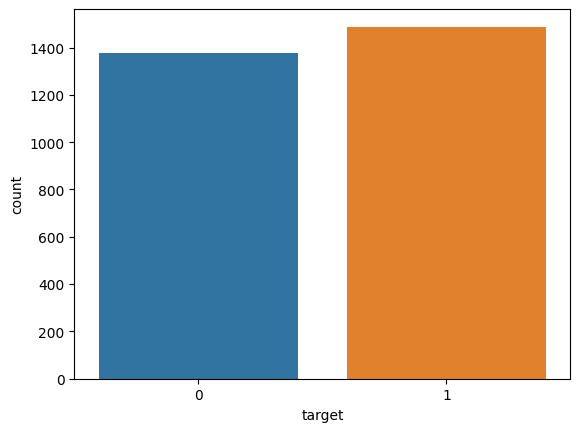

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='target', data=df)

### Pre-training Model

In this section take a sample value from the target that will be used as a reference for other values

In [ ]:
df["texts"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'Cool place, comfortable, clean, unlike other squares, this place has a unique architecture and layout'

Data pre-processing using Regular Expression. Removes HTML tags: replaces anything between opening and closing <> with empty space

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

Use the nltk library to download stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Install emoji and re

In [ ]:
!pip install emoji
import emoji
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=38ec36c7279606b2714a99f5baf2ff9f64c3a46889b56b8bcbd978c3dc3ec5d3
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji


Process the data to remove unnecessary characters and emoji

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    # Menghapus emoji
    esentence = emoji.demojize(sentence)
    sentence = re.sub(r':[^:]+:', '', sentence)

    # Menghapus semua tanda baca
    sentence = re.sub(r'[.,?!()=*+\-&]', ' ', sentence)

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

Calling preprocessing_text function on destination_reviews with the code below

In [ ]:
# Calling preprocessing_text function on destination_reviews

X = []
sentences = list(df['texts'])
for sen in sentences:
    X.append(preprocess_text(sen))

Print the target value to ensure that the sample is completely clean

In [ ]:
# Sample cleaned up

X

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

['monday many tours surabaya closed ',
 'great place sightseeing spending time friends family',
 'cool place comfortable clean unlike squares place unique architecture layout',
 'place education citizens surabaya particular society general ',
 'really good',
 'lots good smooth',
 'clean well maintained bright cool',
 'suroboyo children creative activity center always well maintained municipal government surabaya',
 'several times first time smoke fountain appears yeeaay',
 'good familyable',
 'unique',
 'surabaya icon exciting',
 'surabaya residents must come take part activities every weekend namely creative home training',
 'place nice could icon surabaya ',
 'first time turned good compared jakarta pay different enter art museum free parking also free wow',
 'cozy atmosphere gallery',
 'really good',
 'many good spots take pictures make memories surabaya',
 'really crowded nighttime go ',
 'highly recommended holding event balai pemuda even though air super hot outside sby ',
 'plac

Converting sentiment labels to 0 & 1

In [ ]:
# Converting sentiment labels to 0 & 1

y = df['target']


The train set will be used to train our deep learning models
while test set will be used to evaluate how well our model performs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Embedding layer expects the words to be in numeric form

Using Tokenizer function from keras.preprocessing.text library

Method fit_on_text trains the tokenizer

Method texts_to_sequences converts sentences to their numeric form

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

Adding 1 to store dimensions for words for which no pretrained word embeddings exist

In [ ]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

3244

Padding all reviews to fixed length 100

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Load GloVe word embeddings and create an Embeddings Dictionary

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/Othercomputers/My Laptop/Bangkit Academy/capstone project/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Create Embedding Matrix having 100 columns

Containing 100-dimensional GloVe word embeddings for all words in our corpus.

In [ ]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Do embedding_metrix.shape to know embedding matrix rows and columns

In [ ]:
embedding_matrix.shape

(3244, 100)

## Model Training

Create a neural network architecture using **CNN Model** to make model training :
Convolution 1D, ReLu, Sigmoid, optimizer Adam, and Binary Crossentropy

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

Create a model compiling and print the summary model

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          324400    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 388,657
Trainable params: 64,257
Non-trainable params: 324,400
_________________________________________________________________
None


Train the model with 50 epochs

In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 10s 50ms/step - loss: 0.5913 - acc: 0.7017 - val_loss: 0.5358 - val_acc: 0.7473
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 0.4373 - acc: 0.8097 - val_loss: 0.4855 - val_acc: 0.7625
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 0.3627 - acc: 0.8582 - val_loss: 0.4725 - val_acc: 0.7821
Epoch 4/50
15/15 [==============================] - 0s 8ms/step - loss: 0.3126 - acc: 0.8850 - val_loss: 0.4637 - val_acc: 0.8017
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.2756 - acc: 0.9073 - val_loss: 0.4833 - val_acc: 0.7887
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 0.2457 - acc: 0.9220 - val_loss: 0.4556 - val_acc: 0.7974
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 0.2182 - acc: 0.9335 - val_loss: 0.4539 - val_acc: 0.7887
Epoch 8/50
15/15 [==============================] - 0s 7ms/step - loss: 0.1964 - acc: 0.

Make predictions on the test set how much loss value and accuracy value

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

18/18 [==============================] - 0s 8ms/step - loss: 0.5787 - acc: 0.7979


Print the model performance include test score and test accuracy

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5786847472190857
Test Accuracy: 0.7979093790054321


Make the line chart to compare the model accuracy and model loss

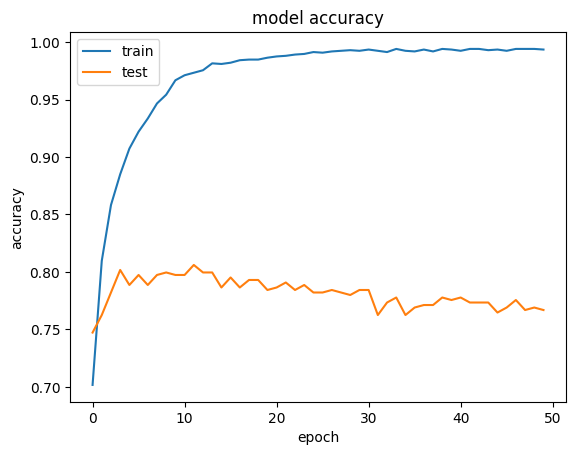

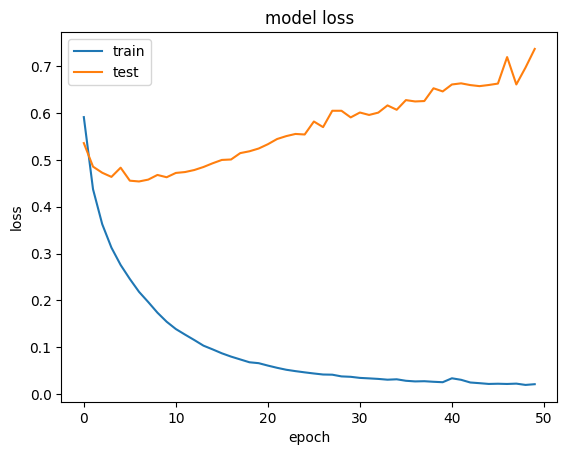

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Saving the model as a h5 file for possible use later

In [ ]:
cnn_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

## Making Prediction From the Data

Show the top 6 dataset from the dataframe

In [ ]:
# Load sample data

df.head(6)

,target,texts
0,0,"Monday, Many tours in Surabaya are closed."
1,1,Great Place for sightseeing and spending time ...
2,1,"Cool place, comfortable, clean, unlike other s..."
3,1,Place of education for the citizens of Surabay...
4,1,Really good
5,1,Lots of good smooth


Preprocess review text with earlier defined preprocess_text function

In [ ]:
reviews =df['texts']

processed = []
for review in reviews:
  review = preprocess_text(review)
  processed.append(review)

Make Tokenising instance with earlier trained tokeniser and Pooling instance to have maxlength of 100 tokens

In [ ]:
# Tokenising instance with earlier trained tokeniser
tokenized2 = word_tokenizer.texts_to_sequences(processed)

# Pooling instance to have maxlength of 100 tokens
padded2 = pad_sequences(tokenized2, padding='post', maxlen=maxlen)

Passing tokenised instance to the **CNN model** for predictions

In [ ]:
sentiments = cnn_model.predict(padded2)

sentiments

90/90 [==============================] - 0s 3ms/step


array([[0.00112567],
       [0.9999974 ],
       [0.99996746],
       ...,
       [0.00935577],
       [0.08203949],
       [0.9992884 ]], dtype=float32)

 Writing model output file back to Google Drive

In [ ]:
df['Predicted Sentiments'] = np.round(sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(df['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_target                = pd.DataFrame(df['target'], columns = ['target'])
df_texts                 = pd.DataFrame(df['texts'], columns = ['texts'])


dfx=pd.concat([df_target, df_texts, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,target,texts,Predicted Sentiments
0,0,"Monday, Many tours in Surabaya are closed.",0.0
1,1,Great Place for sightseeing and spending time ...,10.0
2,1,"Cool place, comfortable, clean, unlike other s...",10.0
3,1,Place of education for the citizens of Surabay...,10.0
4,1,Really good,9.2
5,1,Lots of good smooth,10.0


Show the result of prediction

In [ ]:
sentence2 = ["Its a nice place to escape the busy life of Surabaya. The park is simple yet beautiful, clean and well maintained."]

tokenized22 = word_tokenizer.texts_to_sequences(sentence2)
# Pooling instance to have maxlength of 100 tokens
padded22 = pad_sequences(tokenized22, padding='post', maxlen=maxlen)


print(cnn_model.predict(padded22))

1/1 [==============================] - 0s 53ms/step
[[0.99406624]]


# **Convert to Tflite**

Converting TensorFlow models to TensorFlow Lite format can take a few paths depending on the content of your ML model. As the first step of that process, you should evaluate your model to determine if it can be directly converted. This evaluation determines if the content of the model is supported by the standard TensorFlow Lite runtime environments based on the TensorFlow operations it uses. If your model uses operations outside of the supported set, you have the option to refactor your model or use advanced conversion techniques.

1. Converting a tf.Keras model to a TensorFlow Lite model
2. Keras model: A model created using the high level Keras API.
3. Open the model.tflite to connect deploy

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)